<a href="https://colab.research.google.com/github/eujin99/SNN-TIL/blob/main/Brian2_Neurons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brian2

## Introduction to Brian part 1 : Neurons



In [27]:
!pip install brian2

In [28]:
from brian2 import *

## 1. 1차 ODE (상미분)


```v``` : 뉴런의 막전위 같은 상태 변수 (현재값)

```T``` : 시간 상수(time constant), “얼마나 빨리 변하는가”를 조절하는 값

```1 - v``` : 목표값(==1) 과 현재값(==v) 의 차이

v는 시간이 흐르면 결국 1에 수렴함. (컵 비유)


뉴런 방정식을 Brian2 로 적는 방법

```"시간에 따라 어떤 값이 특정 목표로 수렴한다"``` 는 개념

여기서 threshold, reset 붙이면 ```스파이킹 뉴런 모델``` 됨


```brian2 로 식쓰기```

eqs = '''
dv/dt = (1 - v)/tau : 1
'''

```: 1``` => 단위 없는 변수 라는 뜻

Brian2 는 모든 식의 단위 일치를 검사함

```좌변 dv/dt``` -> 단위는 1/시간

```우변 (1-v)/tau``` -> (단위 없음) / (시간) = 1/시간

** 만약에 ```tau``` 를 나눠주지 않으면 ```dv/dt = 1-v``` 는 단위가 1인데, 좌변은 1/시간

이므로 불일치 에러 발생

In [29]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1 - v)/tau : 1
'''
G = NeuronGroup(1, eqs, method='exact')  # 적분법
print('Before v =', G.v[0]) # 초기값 (기본 0)
run(100*ms)
print('After  v =', G.v[0]) # 시간이 지나면 1에 가까워짐

# 이론값 비교: v(t)=1-exp(-t/tau)
print('Expected =', 1 - exp(-100*ms/tau))


Before v = 0.0
After  v = 0.9999546000702376
Expected = 0.9999546000702375


100ms 동안 시뮬레이션 했더니 v가 1에 거의 수렴

그래프로 본다면, 지수함수 형태로 0부터 1에 가까워지는 곡선 나옴

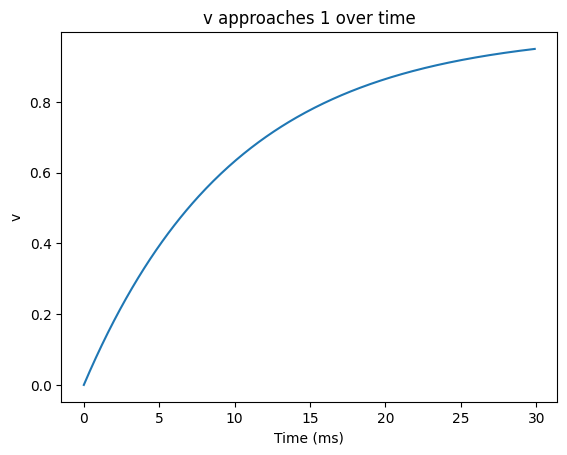

In [30]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1 - v)/tau : 1
'''
G = NeuronGroup(1, eqs, method='exact')
M = StateMonitor(G, 'v', record=True)

run(30*ms)

plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v')
title('v approaches 1 over time')
show()


## 2. 시간 의존 입력을 넣은 ODE (사인파)

```sin(2*pi*f*t)``` 처럼 t(==시간)을 식에 직접 사용 가능

```method='euler'``` 은 일반적인 시간 의존식, 확률식에서 안전한 기본값

그래프는 사인파에 끌려가되, ```tau``` 때문에 지연(위상 차) 과 감쇠 (저역통과처럼 부드러워짐) 가 나타남


In [31]:
start_scope()

In [32]:
# 시뮬레이션 해상도 명시: 너무 크게 잡으면 진동이 깨집니다.
defaultclock.dt = 0.1*ms   # 0.1ms 해상도

tau = 10*ms
f = 100*Hz   # 입력 사인파 주파수 (100Hz)

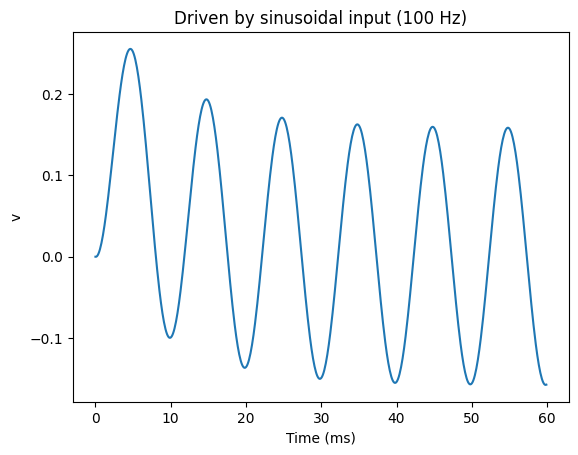

In [33]:
eqs = '''
dv/dt = (sin(2*pi*f*t) - v)/tau : 1
f : Hz
'''

G = NeuronGroup(1, eqs, method='euler')  # 시간 의존 입력 → euler(오일러) 사용
G.f = f
G.v = 0  # 초기값

M = StateMonitor(G, 'v', record=True)

run(60*ms)

plot(M.t/ms, M.v[0])
xlabel('Time (ms)'); ylabel('v')
title('Driven by sinusoidal input (100 Hz)');
show()

## 2-1. 파라미터 바꿔보기 (주피수/시간상수)

```주파수 상승``` : 더 빠른 입력은 필터링 되어 진폭이 줄고 위상이 더 밀려남

```tau 상승``` : 더 무거운 시스템이 되어 변화가 느리고, 입력을 더 많이 "평균" 함, 느리게 따라감

같은 입력이라도 시스템 시간 상수에 따라 반응이 다름



WARNING    'f' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 200. * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    't' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 38. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


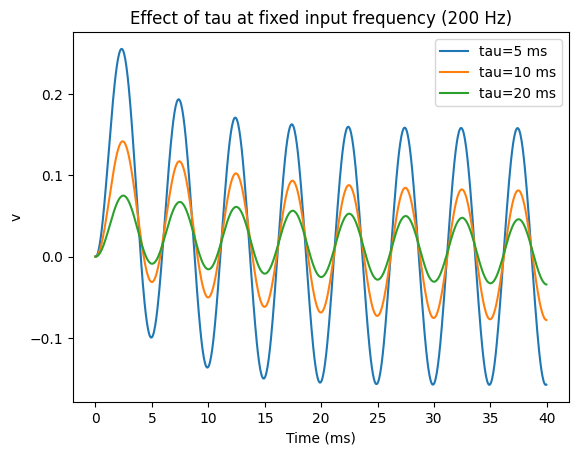

In [34]:
start_scope()
defaultclock.dt = 0.05*ms  # 조금 더 촘촘히

taus = [5*ms, 10*ms, 20*ms]
f = 200*Hz

eqs = '''
dv/dt = (sin(2*pi*f*t) - v)/tau : 1
tau : second
f : Hz
'''

G = NeuronGroup(len(taus), eqs, method='euler')
G.tau = taus
G.f = f
G.v = 0

M = StateMonitor(G, 'v', record=True)
run(40*ms)

for i, tau in enumerate(taus):
    plot(M.t/ms, M.v[i], label=f'tau={tau/ms:.0f} ms')
xlabel('Time (ms)'); ylabel('v'); legend()
title('Effect of tau at fixed input frequency (200 Hz)')
show()


## 2-2. ```exact``` vs ```euler```

경우에 따른 선택을 하면 됨

1. ```exact```

: 식이 아주 단순 (선형/상수 계수 등) 해서 Brian2가 해석해를 아는 경우 사용

: 정확하고 빠름

2. ```euler```

: 일반적인 시간 의존 입력, 비선형 항, 잡음 포함 등 닫힌해가 없는 경우 사용

: 시간 간격 defaultclock.dt 를 너무 크게 잡으면 진동이 부정확해질 수 있으니, 입력 주파수와 tau에 비해 충분히 작게 잡는 것이 좋음



---

입력이 빠를수록 ```dt```를 더 작게 설정

결과가 들쭉날쭉하거나 진폭/위상이 이상하면 ```dt``` 를 줄여서 다시 확인


## 2-3. 사용자 정의 시간 입력 (샘플 시퀀스 -> TimedArray)

사인 대신 임의의 파형 (측정한 자극) 을 쓰고 싶을 때는 ```TimeArray``` 사용

```inp = TimeArray(wave, dt=...)``` 로 샘플 배열을 시간 함수처럼 사용할 수 있음

식에서는 ```int(t)``` 로 참조

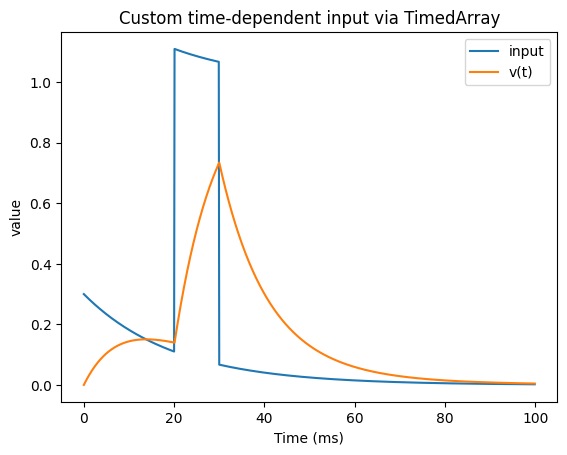

In [35]:
start_scope()
defaultclock.dt = 0.1*ms

# 예시: 0~100ms 동안 임의 파형(펄스 + 감쇠)
duration = 100*ms
times = arange(0*ms, duration, defaultclock.dt)
wave = zeros(len(times))
wave[(times>20*ms) & (times<30*ms)] = 1.0    # 20~30ms에 펄스
wave += 0.3*exp(-(times/20/ms))              # 지수 감쇠 꼬리 추가

inp = TimedArray(wave, dt=defaultclock.dt)

tau = 10*ms
eqs = '''
dv/dt = (inp(t) - v)/tau : 1
'''

G = NeuronGroup(1, eqs, method='euler')
M = StateMonitor(G, 'v', record=True)
run(duration)

plot(times/ms, wave, label='input')
plot(M.t/ms, M.v[0], label='v(t)')
xlabel('Time (ms)'); ylabel('value'); legend()
title('Custom time-dependent input via TimedArray')
show()


## 3. spike & reset

2번 단계 까지는 값 v 가 1에 수렴하는 연속 변수였음

3번부터는 임계값 (threshold) 을 넘으면 스파이크가 발생하고, 막전위를 reset 하는 규칙을 붙임



---



```threshold = 'v > 0.8' ``` : v 값이 8 넘으면 스파이크 발생

```reset = 'v = 0'``` : 스파이크 직후 막전위 0으로 초기화

```SpikeMonitor``` : 언제 스파이크 발생했는지 시간 기록

```StateMonitor``` : v(t)의 시간 변화 기록

스파이크 발생 시간 (ms): [16.  32.1 48.2]


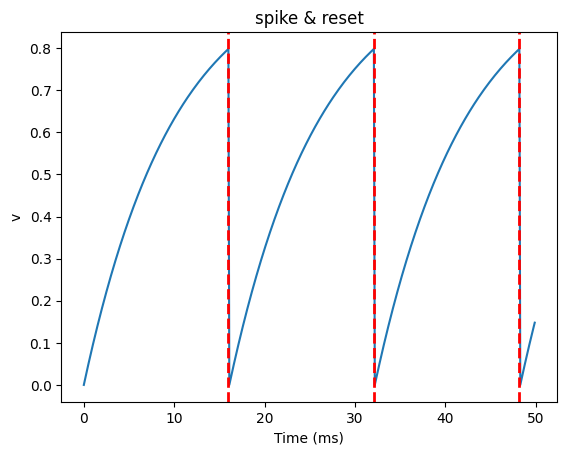

In [36]:
from brian2 import *

start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1 - v)/tau : 1
'''

# threshold: 임계값, reset: 발화 후 값 되돌림
G = NeuronGroup(1, eqs, threshold='v > 0.8', reset='v = 0', method='exact')

# v값이 8넘으면 스파이크 발생

# 기록 장치
statemon = StateMonitor(G, 'v', record=0)   # 전위 기록
spikemon = SpikeMonitor(G)                  # 스파이크 시점 기록

run(50*ms)

print("스파이크 발생 시간 (ms):", spikemon.t/ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:   # 스파이크 시점마다 세로선 표시
    axvline(t/ms, ls='--', lw=2, color='r')
xlabel('Time (ms)')
ylabel('v')
title('spike & reset')
show()


그래프에서 곡선이 임계선 (0.8) 을 넘는 순간마다 세로선(빨강)이 그어지고, v는 0으로 리셋되는 모습

천천히 상승하다가 -> 스파이크 -> 다시 상승



---



스파이크 모델의 최소 요소 : ```임계값``` , ```리셋 규칙```

이런 방식으로 단순화한 뉴런 : ```Integrate-and-Fire```

지금은 "막전위 = 1" 로 수렴하는 시스템에 threshold / reset 을 붙인거고, 뒤에서는 더 복잡한 규칙 (불응기, noise 등)을 얹을 수 있음

## 4. Refractory period (불응기) 적용

불응기 (Refractory period) : spike 직후 잠깐 동안은 다시 발화하지 못하게 만드는 시간

```refractory = 5*ms``` 처럼 불응 시간 지정

미분방정식 뒤에 ```(unless refractory)``` 붙이면 불응기 동안 변수 업데이트(적분)도 멈춤

스파이크(ms): [16. 37.]


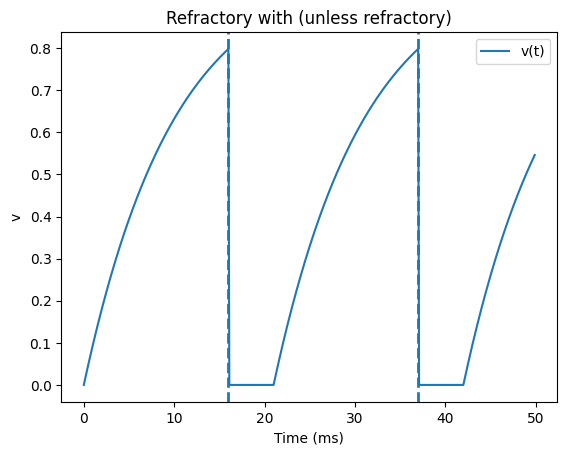

In [37]:
# 불응기 + (unless refractory) 테스트해보기

from brian2 import *

start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1 - v)/tau : 1 (unless refractory)
'''

G = NeuronGroup(
    1, eqs,
    threshold='v > 0.8',
    reset='v = 0',
    refractory=5*ms,       # 스파이크 후 5ms 동안 재spike 불가 + 위 식이 멈춤
    method='exact'
)

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

print("스파이크(ms):", spikemon.t/ms)

plot(statemon.t/ms, statemon.v[0], label='v(t)')
for t in spikemon.t:
    axvline(t/ms, ls='--', lw=2)
xlabel('Time (ms)'); ylabel('v'); title('Refractory with (unless refractory)'); legend(); show()


불응기 동안에는 ```v``` 고정 (그래프에선 0으로 유지)

그래프에서 리셋 후 평평한 구간이 잠깐 보임

스파이크(ms): [ 8. 23. 38.]


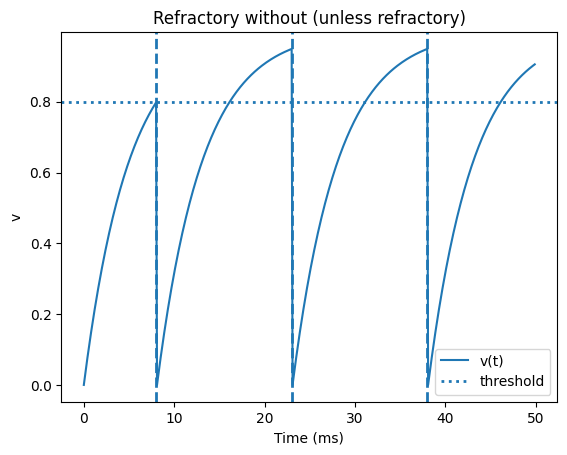

In [38]:
# 불응기만 적용, 적분은 계속하는 경우 테스트해보기

start_scope()

tau = 5*ms
eqs = '''
dv/dt = (1 - v)/tau : 1
'''

G = NeuronGroup(
    1, eqs,
    threshold='v > 0.8',
    reset='v = 0',
    refractory=15*ms,      # 이 시간 동안 v가 다시 threshold를 넘어도 spike 만 금지, 계산은 계속함
    method='exact'
)

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

print("스파이크(ms):", spikemon.t/ms)

plot(statemon.t/ms, statemon.v[0], label='v(t)')
axhline(0.8, ls=':', lw=2, label='threshold')
for t in spikemon.t:
    axvline(t/ms, ls='--', lw=2)
xlabel('Time (ms)'); ylabel('v'); title('Refractory without (unless refractory)'); legend(); show()


불응기에도 ```v```는 다시 올라감 (적분은 계속)

다만 불응기가 끝나기 전에 threshold 를 넘어도 spike 발생하지 않음

불응기 종료 시점 이후 threshold를 넘으면 그제서야 spike 발생

## 5. Noise 적용
뉴런에 랜덤 변동 (채널 노이즈, 입력 변동 등) 이 있는 경우를 재현

실제 뇌 속에서 시냅스 입력이나 이온 채널의 열림/닫힘이 확률적이듯 랜덤성을 추가해주는 것임

WARNING    'i' is an internal variable of group 'neurongroup_4', but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


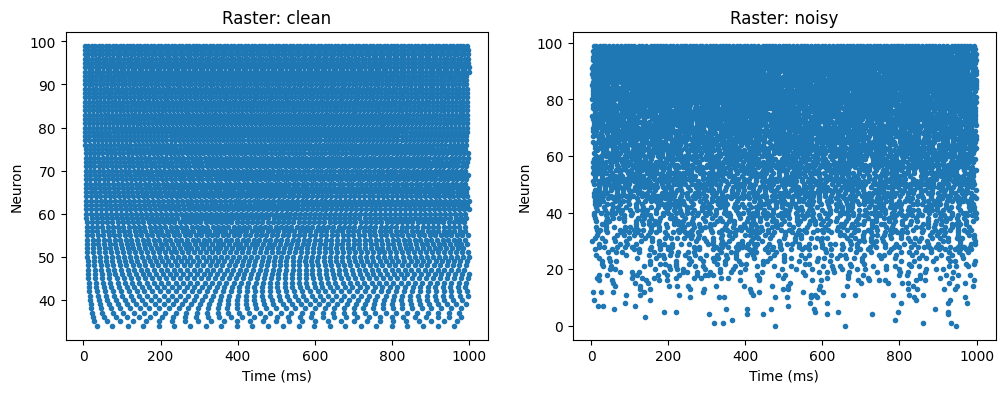

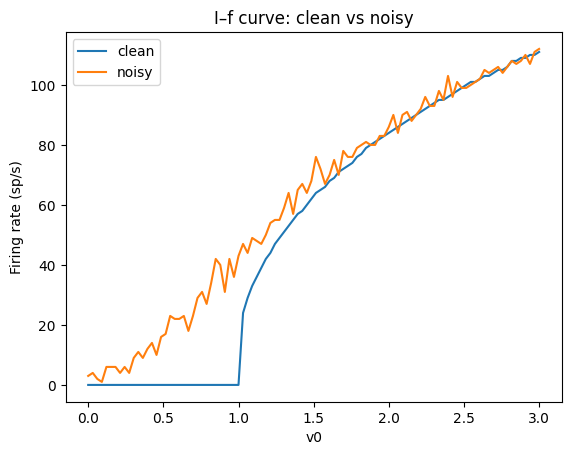

In [39]:
# 여러 뉴런의 I-f 곡선 (스파이크 발생수) 비교
# noise가 있고, 없고에 따라 비교 테스트 해보기

start_scope()
defaultclock.dt = 0.1*ms  # 너무 크면 노이즈 적분이 거칠어짐

N = 100
duration = 1000*ms
tau = 10*ms
v0_max = 3.0

# (A) noise 없는 모델
eqs_clean = '''
dv/dt = (v0 - v)/tau : 1 (unless refractory)
v0 : 1
'''
G_clean = NeuronGroup(N, eqs_clean, threshold='v>1', reset='v=0', refractory=5*ms, method='exact')
G_clean.v0 = 'i * v0_max / (N-1)'
M_clean = SpikeMonitor(G_clean)

# (B) noise 있는 모델
# 노이즈 크기 = sigma
# sigma 를 더 크게 하면 spike 발생 수가 확실히 올라가고, I-f 곡선이 부드러워짐
sigma = 0.5
eqs_noisy = '''
dv/dt = (v0 - v)/tau + sigma*xi*tau**-0.5 : 1 (unless refractory)
v0 : 1
'''
G_noisy = NeuronGroup(N, eqs_noisy, threshold='v>1', reset='v=0', refractory=5*ms, method='euler')
G_noisy.v0 = 'i * v0_max / (N-1)'
M_noisy = SpikeMonitor(G_noisy)

# 동시 비교 위해 같은 시간 시뮬레이션
net = Network(collect())   # 현재 오브젝트 수집
net.add(M_clean, M_noisy)
net.run(duration)

# 래스터 비교
figure(figsize=(12,4))
subplot(121); plot(M_clean.t/ms, M_clean.i, '.'); xlabel('Time (ms)'); ylabel('Neuron'); title('Raster: clean')
subplot(122); plot(M_noisy.t/ms, M_noisy.i, '.'); xlabel('Time (ms)'); ylabel('Neuron'); title('Raster: noisy')
show()

# I–f 곡선 비교
rate_clean = M_clean.count / duration
rate_noisy = M_noisy.count / duration

plot(G_clean.v0, rate_clean, label='clean')
plot(G_noisy.v0, rate_noisy, label='noisy')
xlabel('v0'); ylabel('Firing rate (sp/s)'); title('I–f curve: clean vs noisy'); legend(); show()


clean 그래프는 v0 가 threshold 근처(약 1) 일때, spike 발생수가 갑자기 확 꺾여 올라가는 모양

noisy 그래프는 v0 가 threshold 보다 작을 때도 스파이크가 살짝 발생하고 곡선이 부드럽게 올라가는 모양



---





noise 유무의 차이를 크게 하려면 :

```sigma```를 더 크게하고, ```시뮬레이션 시간```을 줄이고, ```뉴런 수```를 줄이기

